In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
from torchvision.transforms import Resize
from torch.utils.data import DataLoader

In [2]:
# Load Data

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform=Compose( [Resize((32,32)),ToTensor()]), 
    download = True           
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform=Compose( [Resize((32,32)),ToTensor()]),
    download = True 
)


training_index = np.zeros(6000)
ytrain_count = np.zeros(10)

pics_limit = 600
count = 0
for i in range(len(train_data)):
    if ytrain_count[train_data[i][1]] < pics_limit: 
        training_index[count] = i
        count +=1
        ytrain_count[train_data[i][1]] +=1
        

In [3]:
train_data = DataLoader(train_data,sampler=torch.tensor(training_index).long(), batch_size=16,num_workers=0)
test_data = DataLoader(test_data,num_workers=0)

# CNN with SGD

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn = nn.Sequential(

            # Conv(001, 064, 3, 1, 1) - BatchNorm(064) - ReLU - MaxPool(2, 2)
            nn.Conv2d(1, 64, kernel_size=3, padding=1,stride = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv(064, 128, 3, 1, 1) - BatchNorm(128) - ReLU - MaxPool(2, 2)
            nn.Conv2d(64, 128, kernel_size=3, padding=1,stride = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv(128, 256, 3, 1, 1) - BatchNorm(256) - ReLU
            nn.Conv2d(128, 256, kernel_size=3, padding=1,stride = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
             
            # Conv(256, 256, 3, 1, 1) - BatchNorm(256) - ReLU - MaxPool(2, 2)
            nn.Conv2d(256, 256, kernel_size=3, padding=1,stride = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv(256, 512, 3, 1, 1) - BatchNorm(512) - ReLU
            nn.Conv2d(256, 512, kernel_size=3, padding=1,stride = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            # Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU - MaxPool(2, 2)
            nn.Conv2d(512, 512, kernel_size=3, padding=1,stride = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            #  Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU
            nn.Conv2d(512, 512, kernel_size=3, padding=1,stride = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            # Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU - MaxPool(2, 2)
            nn.Conv2d(512, 512, kernel_size=3, padding=1,stride = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.linear_layer = nn.Sequential(
 
            # Linear(0512, 4096) - ReLU - Dropout(0.5)
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            # Linear(4096, 4096) - ReLU - Dropout(0.5)
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10),
        )
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1) 
        x = self.linear_layer(x) 
        return x

In [5]:
n_epochs = 20
train_loss_record = np.zeros(n_epochs)
test_loss_record = np.zeros(n_epochs)
train_acc_record = np.zeros(n_epochs) 
test_acc_record = np.zeros(n_epochs)
model = CNN()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05,momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [6]:
for epoch in range(n_epochs):
    # Monitor training loss
    train_loss = 0.0
    test_loss = 0.0
    train_acc = 0
    test_acc = 0
    # Prep model for training
    model.train() 
    for data, target in train_data:
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        _, predicted = torch.max(output, dim=1)
        # Calculate the loss
        loss = criterion(output, target)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        

    # Prep model for evaluation
    model.eval() 
    with torch.no_grad():      
        for data, target in train_data:
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            _, predicted = torch.max(output, dim=1)
            # Calculate the loss
            loss = criterion(output, target)
            train_loss += loss.item()*data.size(0)
            train_acc += (predicted == target).sum().item()
        for data, target in test_data:
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            _, predicted = torch.max(output, dim=1)
            # Calculate the loss
            loss = criterion(output, target)
            # Update running validation loss 
            test_loss += loss.item()*data.size(0)
            test_acc += (predicted == target).sum().item()
    # Print training/validation statistics 
    # Calculate average loss over an epoch
    train_loss_record[epoch] = train_loss/6000
    test_loss_record[epoch] = test_loss/len(test_data)
    train_acc_record[epoch] = train_acc/6000
    test_acc_record[epoch] = test_acc/len(test_data)

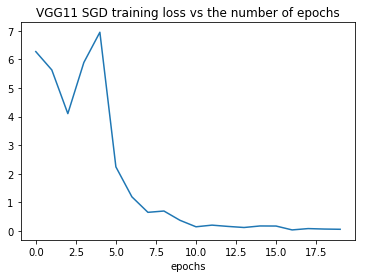

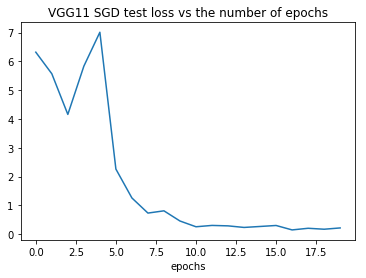

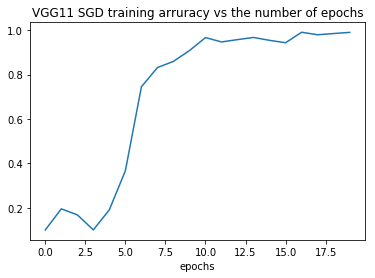

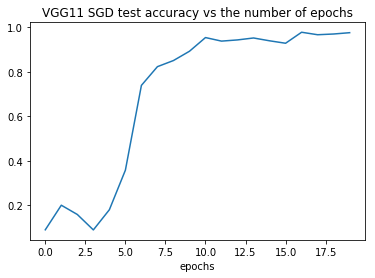

In [7]:
plt.plot(train_loss_record)
plt.title('VGG11 SGD training loss vs the number of epochs')
plt.xlabel('epochs')
plt.show()

plt.plot(test_loss_record)
plt.title('VGG11 SGD test loss vs the number of epochs')
plt.xlabel('epochs')
plt.show()

plt.plot(train_acc_record)
plt.title('VGG11 SGD training arruracy vs the number of epochs')
plt.xlabel('epochs')
plt.show()

plt.plot(test_acc_record)
plt.title('VGG11 SGD test accuracy vs the number of epochs')
plt.xlabel('epochs')
plt.show()

# CNN with ADAM

In [8]:

train_loss_record = np.zeros(n_epochs)
test_loss_record = np.zeros(n_epochs)
train_err_record = np.zeros(n_epochs) 
test_err_record = np.zeros(n_epochs)
model = CNN()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08) 
criterion = nn.CrossEntropyLoss()

In [9]:
for epoch in range(n_epochs):
    # Monitor training loss
    train_loss = 0.0
    test_loss = 0.0
    train_acc = 0
    test_acc = 0
    # Prep model for training
    model.train() 
    for data, target in train_data:
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        _, predicted = torch.max(output, dim=1)
        # Calculate the loss
        loss = criterion(output, target)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        

    # Prep model for evaluation
    model.eval() 
    with torch.no_grad():      
        for data, target in train_data:
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            _, predicted = torch.max(output, dim=1)
            # Calculate the loss
            loss = criterion(output, target)
            train_loss += loss.item()*data.size(0)
            train_acc += (predicted == target).sum().item()
        for data, target in test_data:
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            _, predicted = torch.max(output, dim=1)
            # Calculate the loss
            loss = criterion(output, target)
            # Update running validation loss 
            test_loss += loss.item()*data.size(0)
            test_acc += (predicted == target).sum().item()
    # Print training/validation statistics 
    # Calculate average loss over an epoch
    train_loss_record[epoch] = train_loss/6000
    test_loss_record[epoch] = test_loss/len(test_data)
    train_acc_record[epoch] = train_acc/6000
    test_acc_record[epoch] = test_acc/len(test_data)

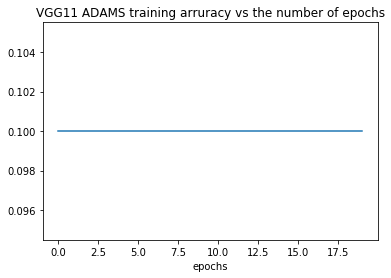

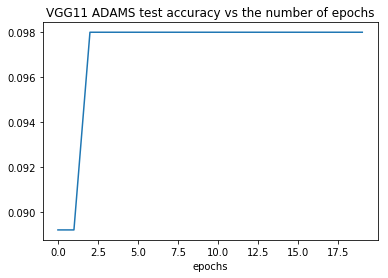

In [10]:
plt.plot(train_acc_record)
plt.title('VGG11 ADAMS training arruracy vs the number of epochs')
plt.xlabel('epochs')
plt.show()

plt.plot(test_acc_record)
plt.title('VGG11 ADAMS test accuracy vs the number of epochs')
plt.xlabel('epochs')
plt.show()

# CNN with sigmoid

In [11]:
class CNN_sigmoid(nn.Module):
    def __init__(self):
        super(CNN_sigmoid, self).__init__()
        self.cnn = nn.Sequential(

            # Conv(001, 064, 3, 1, 1) - BatchNorm(064) - ReLU - MaxPool(2, 2)
            nn.Conv2d(1, 64, kernel_size=3, padding=1,stride = 1),
            nn.BatchNorm2d(64),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv(064, 128, 3, 1, 1) - BatchNorm(128) - ReLU - MaxPool(2, 2)
            nn.Conv2d(64, 128, kernel_size=3, padding=1,stride = 1),
            nn.BatchNorm2d(128),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv(128, 256, 3, 1, 1) - BatchNorm(256) - ReLU
            nn.Conv2d(128, 256, kernel_size=3, padding=1,stride = 1),
            nn.BatchNorm2d(256),
            nn.Sigmoid(),
             
            # Conv(256, 256, 3, 1, 1) - BatchNorm(256) - ReLU - MaxPool(2, 2)
            nn.Conv2d(256, 256, kernel_size=3, padding=1,stride = 1),
            nn.BatchNorm2d(256),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv(256, 512, 3, 1, 1) - BatchNorm(512) - ReLU
            nn.Conv2d(256, 512, kernel_size=3, padding=1,stride = 1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            
            # Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU - MaxPool(2, 2)
            nn.Conv2d(512, 512, kernel_size=3, padding=1,stride = 1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            #  Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU
            nn.Conv2d(512, 512, kernel_size=3, padding=1,stride = 1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            
            # Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU - MaxPool(2, 2)
            nn.Conv2d(512, 512, kernel_size=3, padding=1,stride = 1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.linear_layer = nn.Sequential(
 
            # Linear(0512, 4096) - ReLU - Dropout(0.5)
            nn.Linear(512, 4096),
            nn.Sigmoid(),
            nn.Dropout(0.5),
            
            # Linear(4096, 4096) - ReLU - Dropout(0.5)
            nn.Linear(4096, 4096),
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10),
        )
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1) 
        x = self.linear_layer(x) 
        return x

In [12]:
train_loss_record = np.zeros(n_epochs)
test_loss_record = np.zeros(n_epochs)
train_acc_record = np.zeros(n_epochs) 
test_acc_record = np.zeros(n_epochs)
model = CNN_sigmoid()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05,momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [13]:
for epoch in range(n_epochs):
    # Monitor training loss
    train_loss = 0.0
    test_loss = 0.0
    train_acc = 0
    test_acc = 0
    # Prep model for training
    model.train() 
    for data, target in train_data:
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        _, predicted = torch.max(output, dim=1)
        # Calculate the loss
        loss = criterion(output, target)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        

    # Prep model for evaluation
    model.eval() 
    with torch.no_grad():      
        for data, target in train_data:
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            _, predicted = torch.max(output, dim=1)
            # Calculate the loss
            loss = criterion(output, target)
            train_loss += loss.item()*data.size(0)
            train_acc += (predicted == target).sum().item()
        for data, target in test_data:
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            _, predicted = torch.max(output, dim=1)
            # Calculate the loss
            loss = criterion(output, target)
            # Update running validation loss 
            test_loss += loss.item()*data.size(0)
            test_acc += (predicted == target).sum().item()
    # Print training/validation statistics 
    # Calculate average loss over an epoch
    train_loss_record[epoch] = train_loss/6000
    test_loss_record[epoch] = test_loss/len(test_data)
    train_acc_record[epoch] = train_acc/6000
    test_acc_record[epoch] = test_acc/len(test_data)

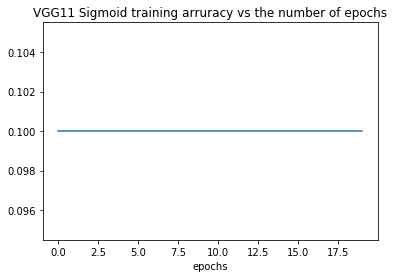

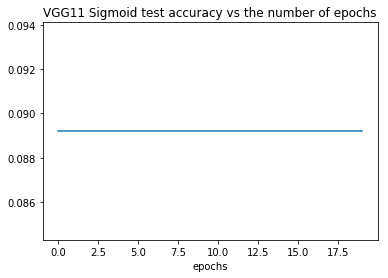

In [14]:
plt.plot(train_acc_record)
plt.title('VGG11 Sigmoid training arruracy vs the number of epochs')
plt.xlabel('epochs')
plt.show()

plt.plot(test_acc_record)
plt.title('VGG11 Sigmoid test accuracy vs the number of epochs')
plt.xlabel('epochs')
plt.show()

# CNN no dropout

In [15]:
class CNN_nodrop(nn.Module):
    def __init__(self):
        super(CNN_nodrop, self).__init__()
        self.cnn = nn.Sequential(

            # Conv(001, 064, 3, 1, 1) - BatchNorm(064) - ReLU - MaxPool(2, 2)
            nn.Conv2d(1, 64, kernel_size=3, padding=1,stride = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv(064, 128, 3, 1, 1) - BatchNorm(128) - ReLU - MaxPool(2, 2)
            nn.Conv2d(64, 128, kernel_size=3, padding=1,stride = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv(128, 256, 3, 1, 1) - BatchNorm(256) - ReLU
            nn.Conv2d(128, 256, kernel_size=3, padding=1,stride = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
             
            # Conv(256, 256, 3, 1, 1) - BatchNorm(256) - ReLU - MaxPool(2, 2)
            nn.Conv2d(256, 256, kernel_size=3, padding=1,stride = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv(256, 512, 3, 1, 1) - BatchNorm(512) - ReLU
            nn.Conv2d(256, 512, kernel_size=3, padding=1,stride = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            # Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU - MaxPool(2, 2)
            nn.Conv2d(512, 512, kernel_size=3, padding=1,stride = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            #  Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU
            nn.Conv2d(512, 512, kernel_size=3, padding=1,stride = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            # Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU - MaxPool(2, 2)
            nn.Conv2d(512, 512, kernel_size=3, padding=1,stride = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.linear_layer = nn.Sequential(
 
            # Linear(0512, 4096) - ReLU - Dropout(0.5)
            nn.Linear(512, 4096),
            nn.ReLU(),
            #nn.Dropout(0.5),
            
            # Linear(4096, 4096) - ReLU - Dropout(0.5)
            nn.Linear(4096, 4096),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(4096, 10),
        )
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1) 
        x = self.linear_layer(x) 
        return x

In [16]:
train_loss_record = np.zeros(n_epochs)
test_loss_record = np.zeros(n_epochs)
train_acc_record = np.zeros(n_epochs) 
test_acc_record = np.zeros(n_epochs)
model = CNN_nodrop()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05,momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [17]:
for epoch in range(n_epochs):
    # Monitor training loss
    train_loss = 0.0
    test_loss = 0.0
    train_acc = 0
    test_acc = 0
    # Prep model for training
    model.train() 
    for data, target in train_data:
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        _, predicted = torch.max(output, dim=1)
        # Calculate the loss
        loss = criterion(output, target)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        

    # Prep model for evaluation
    model.eval() 
    with torch.no_grad():      
        for data, target in train_data:
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            _, predicted = torch.max(output, dim=1)
            # Calculate the loss
            loss = criterion(output, target)
            train_loss += loss.item()*data.size(0)
            train_acc += (predicted == target).sum().item()
        for data, target in test_data:
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            _, predicted = torch.max(output, dim=1)
            # Calculate the loss
            loss = criterion(output, target)
            # Update running validation loss 
            test_loss += loss.item()*data.size(0)
            test_acc += (predicted == target).sum().item()
    # Print training/validation statistics 
    # Calculate average loss over an epoch
    train_loss_record[epoch] = train_loss/6000
    test_loss_record[epoch] = test_loss/len(test_data)
    train_acc_record[epoch] = train_acc/6000
    test_acc_record[epoch] = test_acc/len(test_data)

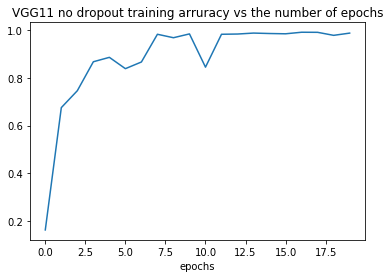

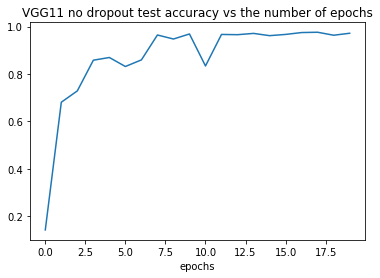

In [18]:
plt.plot(train_acc_record)
plt.title('VGG11 no dropout training arruracy vs the number of epochs')
plt.xlabel('epochs')
plt.show()

plt.plot(test_acc_record)
plt.title('VGG11 no dropout test accuracy vs the number of epochs')
plt.xlabel('epochs')
plt.show()